In [1]:
import torch
import numpy
from ml_modules import *
from sequence_modules import *
from llm_modules import *
from agent import *
from simulation import *

from utils import *

from ml_ops_utils import *

import gc

from hand_strength import *

from matplotlib import pyplot as plt

!nvidia-smi

/home/sachdved/miniconda3/envs/local_llm_host/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mon Feb 23 00:57:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.119.02             Driver Version: 580.119.02     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   31C    P3             46W /  450W |     150MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
num_players = 2  # or up to 8
embed_dim = 256
max_seq_len = 1024
num_streets = 4
device = "cuda"

hand_counter = 0  # track globally across hands
batch_size=1024
small_blind = 1
big_blind = 2
starting_stack_sizes = 400

losses = {0 : [], 1: []}
winnings = {0 : [0], 1 : [0]}

action_validator = PokerActionValidator(
    num_players = num_players,
    small_blind = small_blind,
    big_blind = big_blind,
    starting_stack_sizes = starting_stack_sizes
)

def build_player_components(num_players, embed_dim, max_seq_len, num_streets, device):
    return {
        "street_embedder": StreetPositionalEncoding(num_streets=num_streets, embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device),
        "table_position_embedder": TablePositionalEncoding(num_players=num_players, embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device),
        "action_embedder": ActionEncoding(embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device),
        "pot_size_embedder": PotSizeSequenceEmbedder(max_seq_len=max_seq_len, pad_value=-1, device=device),
        "poker_sequence_embedder": PokerSequenceEmbedder(
            street_input_dimension=embed_dim,
            table_position_input_dimension=embed_dim,
            action_input_dimension=embed_dim,
            latent_dimensions=[embed_dim, embed_dim * 2, embed_dim * 4, embed_dim * 8],
            device=device
        ),
        "cards": Cards(device=device),
        "self_position_embedder": SelfPositionEmbedder(number_of_positions=num_players, device=device),
    }

players = [build_player_components(num_players, embed_dim, max_seq_len, num_streets, device) for _ in range(num_players)]

In [3]:
model_name = "./models/qwen3-1point7b/"

tokenizer, model = load_model(model_name)

model

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.78it/s]
The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2048, out_features=6144, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6144, bias=False)
          (down_proj): Linear(in_features=6144, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen3RMSNorm((2048,), eps=1e-06)
        (post_attention_layer

In [4]:
def build_agent(num_players, embed_dim, max_seq_len, num_streets, device, model):
    self_position_embedder = SelfPositionEmbedder(number_of_positions=num_players, device=device)
    
    cards = Cards(device=device)
    street_embedder = StreetPositionalEncoding(num_streets=num_streets, embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device)
    table_position_embedder = TablePositionalEncoding(num_players=num_players, embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device)
    action_embedder = ActionEncoding(embedding_dim=embed_dim, max_seq_len=max_seq_len, device=device)
    pot_size_embedder = PotSizeSequenceEmbedder(max_seq_len=max_seq_len, pad_value=-1, device=device)
    poker_sequence_embedder = PokerSequenceEmbedder(
        street_input_dimension=embed_dim,
        table_position_input_dimension=embed_dim,
        action_input_dimension=embed_dim,
        latent_dimensions=[embed_dim, embed_dim * 2, embed_dim * 4, embed_dim * 8],
        device=device
    )
    policy_model = PolicyModel(
        num_players=num_players,
        self_position_embedder=self_position_embedder,
        active_players_hidden_dims=[1024, 2048],
        stack_size_hidden_dims=[1024, 2048],
        card_embeddings_hidden_dims=[2048, 2048],
        final_output_hidden_dims=[1024, 512, 256],
        value_output_hidden_dims=[1024, 512, 256],
        dropout_rate=0,
        device=device,
    )
    agent = PokerAgent(
        cards,
        street_embedder,
        table_position_embedder,
        action_embedder,
        pot_size_embedder,
        poker_sequence_embedder,
        model,
        policy_model,
        device=device,
        llm_train=False
    )
    return agent

population_size = num_players  # or set independently, e.g. 8
agents = [build_agent(num_players, embed_dim, max_seq_len, num_streets, device, model) for _ in range(population_size)]
optimizers = [torch.optim.AdamW(agent.parameters(), lr=1e-4) for agent in agents]

In [5]:
optimizers

[AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: True
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0.01
 ),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: True
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0.01
 )]

In [6]:
def place_cards_at_front(deck, card_values):
    """Force specific cards to the front of the deck (e.g. for testing specific hands)."""
    deck = deck.clone()
    for i, card_val in enumerate(card_values):
        current_pos = torch.where(deck == card_val)[1]
        deck[0, current_pos] = deck[0, i].clone()
        deck[0, i] = card_val
    return deck

In [7]:
def build_hand(num_players, batch_size, agents, small_blind, big_blind, starting_stack_sizes, hand_counter, max_seq_len, device='cuda'):
    #deck_order_shuffled = torch.argsort(torch.rand(1, 52))

    # Round-robin: rotate which agents sit in which seats each hand
    population_size = len(agents)
    #seated_agents = [agents[(hand_counter + i) % population_size] for i in range(num_players)]
    seated_agents = [agents[(i) % population_size] for i in range(num_players)]
    
    # Sequence buffers
    street_idxs = (torch.zeros((batch_size, max_seq_len)) + num_streets + 2).long()
    table_position_idxs = (torch.zeros((batch_size, max_seq_len)) + num_players).long()
    action_idxs = (torch.zeros((batch_size, max_seq_len)) + 21).long()
    pot_size_sequence = torch.zeros((batch_size, max_seq_len)) - 1

    # Blind postings (seat 0=SB, seat 1=BB always)
    street_idxs[:, :2] = 0
    table_position_idxs[:, 0] = 0
    table_position_idxs[:, 1] = 1
    action_idxs[:, 0] = 0  # post SB
    action_idxs[:, 1] = 1  # post BB
    pot_size_sequence[:, 0] = small_blind
    pot_size_sequence[:, 1] = small_blind + big_blind

    # Stack sizes
    stack_sizes_init = [
        starting_stack_sizes - small_blind if i == 0
        else starting_stack_sizes - big_blind if i == 1
        else starting_stack_sizes
        for i in range(num_players)
    ]
    active_players = torch.ones((batch_size, num_players))
    stack_size = torch.Tensor(stack_sizes_init).unsqueeze(0).tile(batch_size, 1)

    # Deal hole cards
    player_cards = []
    for i in range(num_players):
        cards = torch.zeros((batch_size, 2, 7), dtype=torch.long, device=device)
        card_indices = deck_order_shuffled[0, i*2 : i*2+2]
        cards[:, 0, :2] = card_indices % 13   # rank
        cards[:, 1, :2] = card_indices // 13  # suit
        cards[:, 0, 2:] = 13  # padding rank
        cards[:, 1, 2:] = 4   # padding suit
        player_cards.append(cards)

    # Build table with round-robin seated agents
    table = {
        i: [seated_agents[i], player_cards[i], torch.Tensor([i]).to(device).tile(batch_size)]
        for i in range(num_players)
    }

    return (
        street_idxs,
        table_position_idxs,
        action_idxs,
        pot_size_sequence,
        active_players,
        stack_size,
        table,
        deck_order_shuffled,
        seated_agents,  # return so you know who played which seat for gradient updates
    )

In [8]:
def compute_log_probs(player_idx, player_action_batch_indices, player_masks, sim_table, sim_street_idxs, sim_table_position_idxs, sim_action_idxs, sim_pot_size_sequence, sim_active_players, sim_stack_size):
    batch_indices = player_action_batch_indices[player_idx]
    
    if batch_indices.numel() == 0:
        return None
    
    mask = player_masks[player_idx]
    position = sim_table[player_idx][2][batch_indices]
    cards = sim_table[player_idx][1][batch_indices]
    street_idxs = sim_street_idxs[batch_indices]
    table_position_idxs = sim_table_position_idxs[batch_indices]
    action_idxs = sim_action_idxs[batch_indices]
    pot_size_sequence = sim_pot_size_sequence[batch_indices]
    active_players = sim_active_players[batch_indices]
    stack_size = sim_stack_size[batch_indices]

    outputs = agents[player_idx](
        position,
        cards,
        street_idxs,
        table_position_idxs,
        action_idxs,
        pot_size_sequence,
        active_players.to('cuda'),
        stack_size.to('cuda')
    )

    taken_actions = sim_action_idxs[batch_indices + 1, mask - 1]
    log_probs = torch.nn.functional.log_softmax(outputs['probits'], dim=-1)
    log_probs_of_taken_actions = log_probs[torch.arange(log_probs.shape[0]), taken_actions]
    return log_probs_of_taken_actions


def compute_loss_and_step(player_idx, player_log_probs, sim_table, optimizers, entropy_coef=0.01):
    log_probs = player_log_probs[player_idx]
    
    if log_probs is None:
        return None
    
    rewards = sim_table[player_idx][-1]
    
    entropy = -(log_probs * log_probs.exp()).sum(dim=-1).mean()
    loss = -(log_probs * rewards).mean() - entropy_coef * entropy
    loss.backward()
    optimizers[player_idx].step()
    optimizers[player_idx].zero_grad()
    return loss.item()

In [9]:
print_gpu_memory("Getting everything started")
num_rollouts = 10
entropy_coef = 0.1
for outer_step in range(10):
    all_hand_inputs = []
    all_rewards = {}

    # --- rollout collection phase (no graphs retained) ---
    for _ in range(num_rollouts):
        deck_order_shuffled = torch.argsort(torch.rand(1, 52))
        deck_order_shuffled = place_cards_at_front(deck_order_shuffled, [12, 25, 0, 18])

        street_idxs, table_position_idxs, action_idxs, pot_size_sequence, \
        active_players, stack_size, table, deck_order_shuffled, seated_agents = build_hand(
            num_players, batch_size, agents, small_blind, big_blind,
            starting_stack_sizes, hand_counter, max_seq_len, device
        )

        (sim_street_idxs, sim_table_position_idxs, sim_action_idxs,
         sim_pot_size_sequence, sim_active_players, sim_stack_size, sim_table) = simulate_hand(
            num_players, street_idxs, table_position_idxs, action_idxs, pot_size_sequence,
            active_players, stack_size, table, action_validator, deck_order_shuffled,
        )
        hand_counter += 1

        rewards = determine_winner(
            sim_active_players[-1],
            sim_pot_size_sequence[-1],
            sim_stack_size[-1],
            sim_table
        )

        next_to_act = action_validator.get_next_to_act(
            sim_street_idxs, sim_table_position_idxs,
            sim_action_idxs, sim_active_players
        )
        player_action_batch_indices = {
            i: torch.where(next_to_act == i)[0] for i in range(num_players)
        }
        player_masks = {
            i: (sim_action_idxs[player_action_batch_indices[i] + 1] == 21).float().argmax(dim=1)
            for i in range(num_players)
            if player_action_batch_indices[i].numel() > 0
        }

        all_hand_inputs.append({
            'player_action_batch_indices': player_action_batch_indices,
            'player_masks': player_masks,
            'sim_table': [[elem.detach() if isinstance(elem, torch.Tensor) else elem
                          for elem in sim_table[i]] for i in range(num_players)],
            'sim_street_idxs': sim_street_idxs.detach(),
            'sim_table_position_idxs': sim_table_position_idxs.detach(),
            'sim_action_idxs': sim_action_idxs.detach(),
            'sim_pot_size_sequence': sim_pot_size_sequence.detach(),
            'sim_active_players': sim_active_players.detach(),
            'sim_stack_size': sim_stack_size.detach(),
        })
        all_rewards[len(all_hand_inputs) - 1] = {i: rewards[i] for i in range(num_players)}

        for i in range(num_players):
            winnings[i].append(winnings[i][-1] + rewards[i].item())

    # --- compute advantages across rollouts (no graphs needed) ---
    advantages = {}
    for player_idx in range(num_players):
        player_rewards = torch.stack([all_rewards[h][player_idx].float() for h in range(num_rollouts)])
        mean_reward = player_rewards.mean()
        std_reward = player_rewards.std() + 1e-8
        advantages[player_idx] = (player_rewards - mean_reward) / std_reward  # shape (num_rollouts,)

    # --- update one hand at a time ---
    for hand_idx, hand_inputs in enumerate(all_hand_inputs):
        for player_idx in range(num_players):
            log_probs = compute_log_probs(
                player_idx,
                hand_inputs['player_action_batch_indices'],
                hand_inputs['player_masks'],
                hand_inputs['sim_table'],
                hand_inputs['sim_street_idxs'],
                hand_inputs['sim_table_position_idxs'],
                hand_inputs['sim_action_idxs'],
                hand_inputs['sim_pot_size_sequence'],
                hand_inputs['sim_active_players'],
                hand_inputs['sim_stack_size'],
            )
            if log_probs is None:
                continue

            entropy = -(log_probs * log_probs.exp()).sum(dim=-1).mean()
            loss = -(log_probs * advantages[player_idx][hand_idx]).mean() - entropy_coef * entropy
            loss.backward()
            optimizers[player_idx].step()
            optimizers[player_idx].zero_grad()
            losses[player_idx].append(loss.item())

        torch.cuda.empty_cache()  # free graph after each hand

    print(f"Step {outer_step} | winnings: {winnings}")
    print_gpu_memory("Finished up one gradient step")

Getting everything started
  Allocated: 4.10 GB
  Reserved:  4.18 GB

Step 0 | winnings: {0: [0, 2.0, 1.0, 3.0, 403.0, 667.0, 666.0, 1066.0, 1466.0, 1689.0, 2089.0], 1: [0, -2.0, -1.0, -3.0, -403.0, -667.0, -666.0, -1066.0, -1466.0, -1689.0, -2089.0]}
Finished up one gradient step
  Allocated: 5.09 GB
  Reserved:  5.52 GB

Step 1 | winnings: {0: [0, 2.0, 1.0, 3.0, 403.0, 667.0, 666.0, 1066.0, 1466.0, 1689.0, 2089.0, 2091.0, 2093.0, 2095.0, 2097.0, 2099.0, 2101.0, 2103.0, 2105.0, 2107.0, 2109.0], 1: [0, -2.0, -1.0, -3.0, -403.0, -667.0, -666.0, -1066.0, -1466.0, -1689.0, -2089.0, -2091.0, -2093.0, -2095.0, -2097.0, -2099.0, -2101.0, -2103.0, -2105.0, -2107.0, -2109.0]}
Finished up one gradient step
  Allocated: 5.09 GB
  Reserved:  5.52 GB

Step 2 | winnings: {0: [0, 2.0, 1.0, 3.0, 403.0, 667.0, 666.0, 1066.0, 1466.0, 1689.0, 2089.0, 2091.0, 2093.0, 2095.0, 2097.0, 2099.0, 2101.0, 2103.0, 2105.0, 2107.0, 2109.0, 2111.0, 2113.0, 2115.0, 2117.0, 2119.0, 2121.0, 2123.0, 2125.0, 2127.0, 212

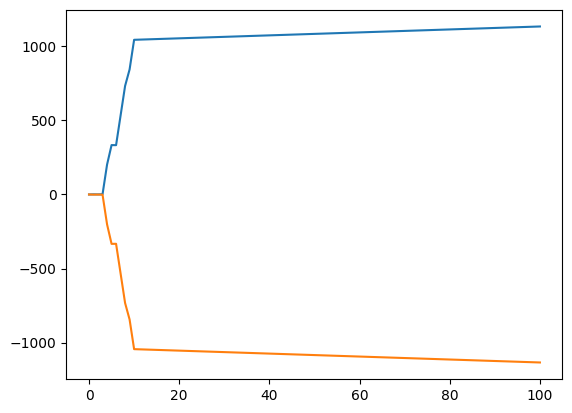

In [10]:
plt.plot([elem/2 for elem in winnings[0]])
plt.plot([elem/2 for elem in winnings[1]])



  Allocated: 32.67 GB
  Reserved:  32.82 GB

